In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
%config InlineBackend.figure_format='retina'
load_dotenv()

output = os.getenv('OUTPUT')

df_subject = pd.read_csv('data/subject_info.csv')
subjects = list(df_subject['id'])

system_colors = {
    'ant':'#003a7d',
    'body':'#4ecc8d',
    'post':'#c700ff'
}
systems = list(system_colors.keys())
min_length=3.0
max_length=150.0


In [ ]:

def get_area_distribution(lengths, areas, bin_width=1.5):

    lengths = np.array(lengths)
    areas = np.array(areas)

    bins = np.arange(
        start=min_length,
        stop=(max_length+bin_width),
        step=bin_width
    )

    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_areas, _ = np.histogram(lengths, bins=bins, weights=areas)

    return bin_centers, bin_areas


bin_width = 1.5

results = {}
for subject in subjects:

    area_distributions = {}

    # N-streamline length numpy arrays with: area (float), length (float), hippocampal system (str: ['ant','body','post]).
    streamline_systems = np.load(f'{output}/{subject}/streamlines-hipp_system.npy')
    streamline_lengths = np.load(f'{output}/{subject}/streamlines-lengths.npy')
    streamline_areas   = np.load(f'{output}/{subject}/streamlines-cross_sectional_areas.npy')


    for system in ['ant','body','post']:

        bin_centers, bin_areas = get_area_distribution(
            streamline_lengths[streamline_systems == system],
            streamline_areas[streamline_systems == system],
            bin_width=bin_width
        )
        area_distributions[system] = (bin_centers, bin_areas)

    results[subject] = area_distributions


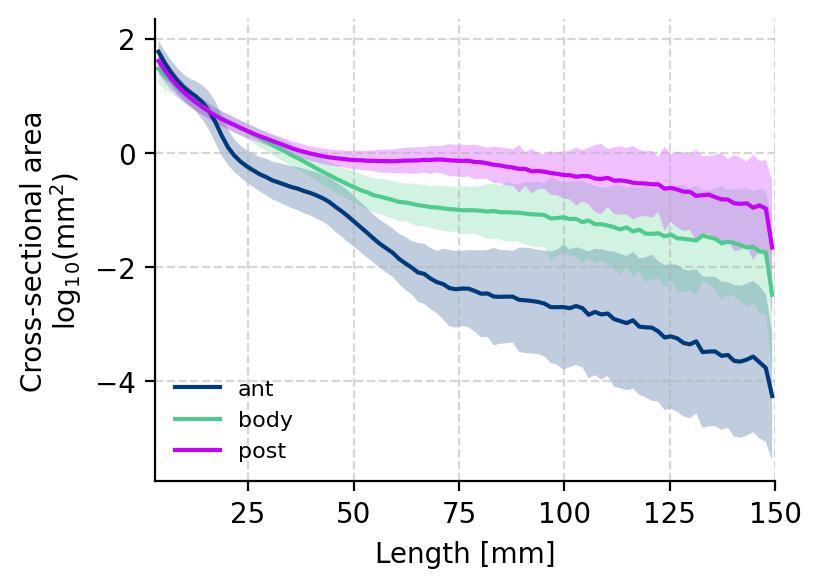

In [20]:

fig, ax = plt.subplots(figsize=(4,3))

for system in ['ant','body','post']:

    area_curves = np.array([results[subject][system][1] for subject in subjects]).T
    area_curves[area_curves == 0] = 1e-5
    area_curves = np.log10(area_curves)
    curve_mean = area_curves.mean(axis=1)
    curve_CI = area_curves.std(axis=1)

    ax.plot(bin_centers, curve_mean, color=system_colors[system], lw=1.5, label=system)
    ax.fill_between(bin_centers, curve_mean+curve_CI, curve_mean-curve_CI, facecolor=system_colors[system], alpha=.25)

ax.set_xlim([min_length, max_length])
ax.grid(linestyle='--', alpha=.5)
ax.set_xlabel('Length [mm]')
ax.set_ylabel('Cross-sectional area\nlog$_1$$_0$(mm$^2$)', linespacing=1, ha='center')

sns.despine()
ax.legend(fontsize=8, loc='lower left', frameon=False)

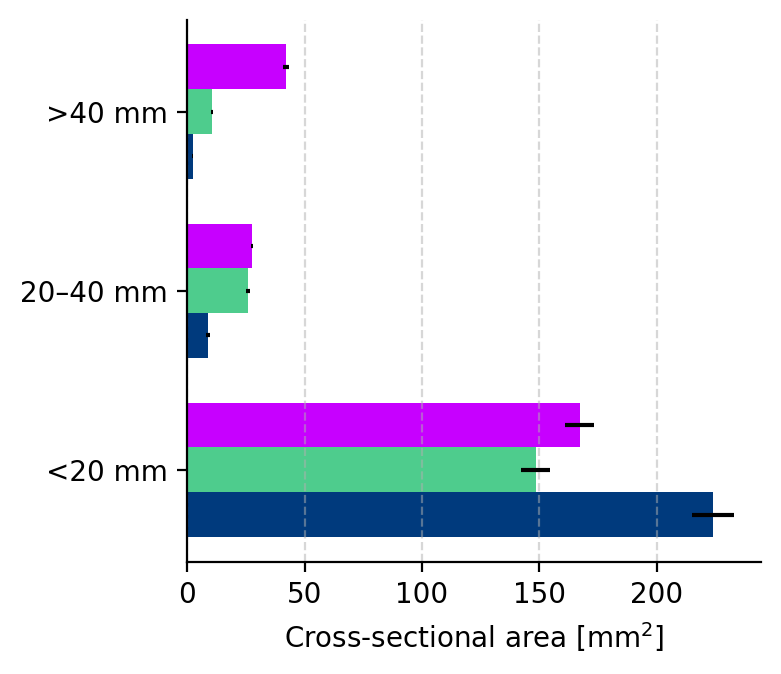

In [ ]:
areas = np.array([
    np.array([results[subject]['ant'][1] for subject in subjects]),
    np.array([results[subject]['body'][1] for subject in subjects]),
    np.array([results[subject]['post'][1] for subject in subjects]),
])
lengths = bin_centers


bins = [(0, 20), (20, 40), (40, np.inf)]
labels = ['<20 mm', '20–40 mm', '>40 mm']

# Compute per-subject total CSA for each bin
n_systems, n_subjects = areas.shape[:2]
totals = np.zeros((n_systems, n_subjects, len(bins)))

for b_i, (lo, hi) in enumerate(bins):
    mask = (lengths >= lo) & (lengths < hi)
    totals[:, :, b_i] = areas[:, :, mask].sum(axis=2)

# Mean ± SD across subjects
mean_csa = totals.mean(axis=1)
ci_csa = 1.96 * (totals.std(axis=1) / np.sqrt(n_subjects))


y = np.arange(len(bins))
height = 0.25

fig, ax = plt.subplots(figsize=(4, 3.5))

for i, sys in enumerate(systems):
    plt.barh(
        y + i * height - height,
        mean_csa[i],
        height,
        xerr=ci_csa[i],
        label=sys,
        color=system_colors[sys]
    )


ax.set_yticks(y, labels)
ax.set_xlabel('Cross-sectional area [mm$^2$]')
ax.set_ylabel('')
ax.grid(linestyle='--', alpha=.5, axis='x')
sns.despine()
plt.tight_layout()
plt.show()
